## Parsing log files

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import os
import re
from pathlib import Path
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
project_dir = Path(".").resolve().parents[0]

In [4]:
lookup_date = "20200424"
log_dir = "logs/"
# log_dir = "logs/slurm" # If on slurm
log_dir = project_dir/log_dir/lookup_date

In [5]:
files = glob.glob(str(log_dir/"*/*/*/*/log-client*"))

## Find index of field we are interested in and beyond

In [6]:
idx = files[0].split("/").index(lookup_date)
mydict = lambda: defaultdict(mydict)
results = mydict()
count = 0
for i, fname in enumerate(files):
    split_path = fname.split("/")
    client_match = re.search(
        r"(?<=log-).+",
        split_path[-1].split(".")[0]
    )
    if client_match:
        split_path[-1] = client_match.group()
    name = "/".join(split_path[idx:])
    with open(fname, "r") as f:
        logfile = f.read()
        train_losses = re.findall(
            r"(?<=train_loss = ).+?(?=,)",
            logfile
        )

        test_losses = re.findall(
            r"(?<=test_loss= ).+?(?=,)",
            logfile
        )
        train_losses = list(map(lambda x: float(x), train_losses))
        test_losses = list(map(lambda x: float(x), test_losses))
        results[name]["train"] =  train_losses
        results[name]["test"] =  train_losses        

In [7]:
def extract_values(obj, query):
    """Pull all values of specified key from nested JSON."""
    result = []
    if isinstance(obj, dict):
        for k, v in obj.items():
            condition = True
            split = k.split("/")
            date = split[-6]
            dataset = split[-5]
            model_type = split[-4]
            optimizer = split[-3]
            run_name = split[-2]
            split_run = run_name.split("-")
            if len(split_run) == 10:
                (n_workers,
                 scenario,
                 quantize,
                 agg_mode,
                 interval,
                 mode,
                 noniid,
                 unbalanced,
                 learning_rate,
                 n_iterations
                ) = split_run
            else:
                (n_workers,
                 scenario,
                 quantize,
                 agg_mode,
                 interval,
                 mode,
                 noniid,
                 unbalanced,
                 learning_rate,
                 n_iterations,
                 delta
                ) = split_run

            condition = eval(query)
            if condition:
                result.append({k: v})
    return result

Found 7 items


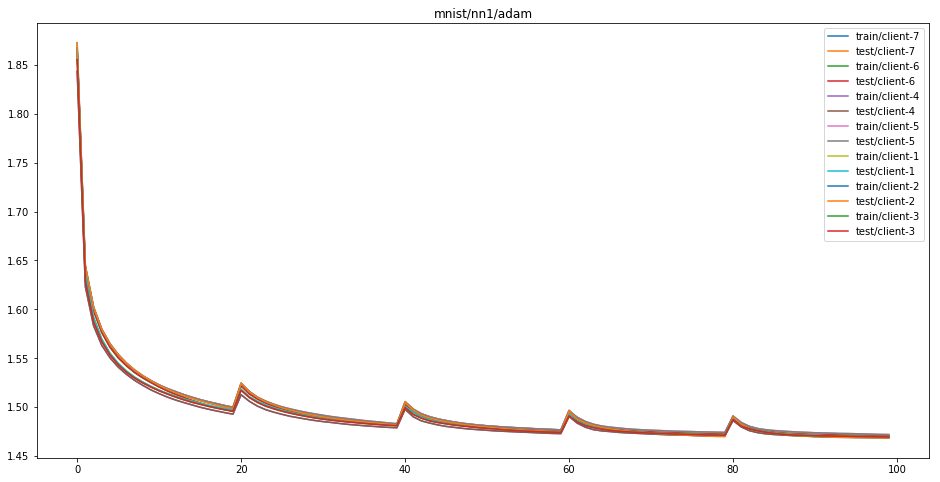

In [8]:
lookup = extract_values(
    results,
    "model_type == 'nn1' and dataset == 'mnist' and optimizer == 'adam'"
    " and learning_rate == '0.001' and interval == '20'"
)

print(f"Found {len(lookup)} items")
if lookup:
    plt.figure(figsize=(16, 8))
    k, v = list(lookup[0].items())[0]
    title = "/".join(k.split("/")[1:-2])
    plt.title(title)
    for l in lookup:
        k, v = list(l.items())[0]
        label = k.split("/")[-1]
        plt.plot(v['train'], label="train/" + label)
        plt.plot(v['test'], label="test/" + label)

    plt.legend()
else:
    print("No results found")